In [20]:
import torch.nn as nn
import torch
# from .modules import *
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
from PIL import Image
import numpy as np

In [2]:
from torch.nn.modules.utils import _pair

In [3]:
from timm.layers import to_2tuple, trunc_normal_,DropPath


In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [5]:
!pip install "https://shi-labs.com/natten/wheels/cu124/torch2.6.0/natten-0.17.5+torch260cu124-cp311-cp311-linux_x86_64.whl"

  Using cached https://shi-labs.com/natten/wheels/cu124/torch2.6.0/natten-0.17.5+torch260cu124-cp311-cp311-linux_x86_64.whl (474.7 MB)


In [6]:
from natten import NeighborhoodAttention2D

In [7]:
from torchvision.ops.misc import SqueezeExcitation

## Multi_branch_module

In [12]:
class Multi_Branch_Module(nn.Module):
    def __init__(self, input_channel, expand_channel, out_channel, large_kernel_size, kernel_size, stride=1, deploy=False):
        super(Multi_Branch_Module, self).__init__()
        self.input_channel = input_channel
        self.expand_channel = expand_channel
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.stride = stride
        self.large_kernel_size = large_kernel_size

        se_input = expand_channel
        se_squeeze = se_input // 4
        self.se = SqueezeExcitation(input_channels=se_input,
                                    squeeze_channels=se_squeeze)

        self.expand_conv = nn.Sequential(
            nn.Conv2d(input_channel, expand_channel,
                      kernel_size=1, stride=1, bias=False), # Bias False before BN
            nn.BatchNorm2d(expand_channel),
            nn.Hardswish(inplace=True)
        )

        if deploy: 
            self.fused_conv = nn.Conv2d(in_channels=expand_channel, out_channels=expand_channel,
                                        kernel_size=large_kernel_size, stride=stride,
                                        padding=large_kernel_size // 2, groups=expand_channel, bias=True)
            self.deploy = True
        else: 
            self.large_conv = nn.Sequential(
                nn.Conv2d(in_channels=expand_channel, out_channels=expand_channel,
                          kernel_size=large_kernel_size, stride=stride,
                          padding=large_kernel_size // 2, groups=expand_channel, bias=False),
                nn.BatchNorm2d(expand_channel)
            )
            self.square_conv = nn.Sequential(
                nn.Conv2d(in_channels=expand_channel, out_channels=expand_channel,
                          kernel_size=kernel_size, stride=stride,
                          padding=kernel_size // 2, groups=expand_channel, bias=False),
                nn.BatchNorm2d(expand_channel)
            )
            self.ver_conv = nn.Sequential(
                nn.Conv2d(in_channels=expand_channel, out_channels=expand_channel,
                          kernel_size=(kernel_size, 1), stride=stride,
                          padding=(kernel_size // 2, 0), groups=expand_channel, bias=False),
                nn.BatchNorm2d(expand_channel)
            )
            self.hor_conv = nn.Sequential(
                nn.Conv2d(in_channels=expand_channel, out_channels=expand_channel,
                          kernel_size=(1, kernel_size), stride=stride,
                          padding=(0, kernel_size // 2), groups=expand_channel, bias=False),
                nn.BatchNorm2d(expand_channel)
            )
            self.deploy = False


        self.active = nn.ReLU() 

        self.pointwise_conv  = nn.Conv2d(expand_channel, out_channel, kernel_size=1, stride=1, padding=0, bias=True) 
        
        if stride > 1 or input_channel != out_channel:
            self.skip = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        elif input_channel == out_channel and stride == 1:
            self.skip = nn.Identity()
        else: 
            self.skip = None


    def forward(self, x):
        identity = x 
        
        x_expanded = self.expand_conv(x)

        if self.deploy:
            out_branches = self.fused_conv(x_expanded)
        else:
            out_branches = self.large_conv(x_expanded)
            out_branches += self.square_conv(x_expanded)
            out_branches += self.ver_conv(x_expanded)
            out_branches += self.hor_conv(x_expanded)

        x_activated = self.active(out_branches)
        x_se = self.se(x_activated)
        x_pointwise = self.pointwise_conv(x_se)

        out_final = x_pointwise + self.skip(identity)
        return out_final

    def fuse_batchnorm(self, conv, bn):
        kernel = conv.weight
        running_mean = bn.running_mean
        running_var = bn.running_var
        gamma = bn.weight
        beta = bn.bias
        eps = bn.eps

        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)

        fused_kernel = kernel * t
        fused_bias = beta - (running_mean * gamma / std)
        return fused_kernel, fused_bias

    def axial_to_square_kernel(self, square_kernel_base, asym_kernel):
        square_kernel = square_kernel_base.clone()
        asym_h = asym_kernel.size(2)
        asym_w = asym_kernel.size(3)
        square_h = square_kernel.size(2)
        square_w = square_kernel.size(3)

        pad_h_start = (square_h - asym_h) // 2
        pad_w_start = (square_w - asym_w) // 2

        square_kernel[:, :, pad_h_start : pad_h_start + asym_h,
                            pad_w_start : pad_w_start + asym_w] += asym_kernel
        return square_kernel

    def get_equivalent_kernel_bias(self):


        large_k, large_b = self.fuse_batchnorm(self.large_conv[0], self.large_conv[1])
        square_k, square_b = self.fuse_batchnorm(self.square_conv[0], self.square_conv[1])
        hor_k, hor_b = self.fuse_batchnorm(self.hor_conv[0], self.hor_conv[1])
        ver_k, ver_b = self.fuse_batchnorm(self.ver_conv[0], self.ver_conv[1])

        fused_small_k = self.axial_to_square_kernel(square_k, hor_k)
        fused_small_k = self.axial_to_square_kernel(fused_small_k, ver_k) 

        total_branch_bias = large_b + square_b + hor_b + ver_b

        padding_val = (self.large_kernel_size - self.kernel_size) // 2
        if padding_val < 0:
            raise ValueError(f"Large kernel size ({self.large_kernel_size}) must be >= kernel size ({self.kernel_size}).")

        if padding_val > 0:
            padded_fused_small_k = F.pad(fused_small_k, [padding_val] * 4)
        else: #
            padded_fused_small_k = fused_small_k

        final_fused_kernel = large_k + padded_fused_small_k

        return final_fused_kernel, total_branch_bias

    def switch_to_deploy(self):
        if self.deploy:
            print("Module is already in deploy mode.")
            return 

        fused_kernel, fused_bias = self.get_equivalent_kernel_bias()

        self.fused_conv = nn.Conv2d(
            in_channels=self.expand_channel,    
            out_channels=self.expand_channel,   
            kernel_size=self.large_kernel_size,
            stride=self.stride,
            padding=self.large_kernel_size // 2,
            groups=self.expand_channel,         
            bias=True                           
        )

        self.fused_conv.weight.data = fused_kernel
        self.fused_conv.bias.data = fused_bias

        self.deploy = True

        self.__delattr__('large_conv')
        self.__delattr__('square_conv')
        self.__delattr__('ver_conv')
        self.__delattr__('hor_conv')

        print(f"Switched module to deploy mode. Fused convolution: {self.fused_conv}")

## Feature pyramid

In [13]:
class FeaturePyramidEmbed(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super().__init__()
        total_in_channels = sum(in_channels_list)
        
        self.conv_embed = nn.Conv2d(
            total_in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.GELU()  
        
    def forward(self, feature_pyramid_list):
        target_size = feature_pyramid_list[-1].shape[2:]  
        
        resized_features = [
            nn.functional.adaptive_avg_pool2d(feat, target_size)
            for feat in feature_pyramid_list[:-1] 
        ]
        resized_features.append(feature_pyramid_list[-1])
        
        concatenated_features = torch.cat(resized_features, dim=1)
        
        embedded_features = self.conv_embed(concatenated_features)
        # embedded_features = self.act(self.bn(embedded_features))
        
        return embedded_features


## GFT

In [14]:
class GlobalAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = qk_scale or self.head_dim ** -0.5
        #self.q = nn.Linear(dim,  2, bias=qkv_bias)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, -1, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q,k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [15]:
class GFT(nn.Module):
    def __init__(self, patchsize, img_size, in_channels, expand_ratios, out_channel, stride, num_heads):
        super(GFT, self).__init__()
        # Patch embedding with overlap
        self.patchembedding = OverlapPatchEmbed(
            patchsize=patchsize, 
            img_size=img_size, 
            in_channels=in_channels,
            embed_dim=in_channels,
            stride=stride
        )
        
        # Layer normalization and attention
        self.norm1 = nn.LayerNorm(in_channels)
        self.attention = GlobalAttention(
            dim=in_channels,
            num_heads=num_heads
        )
        
        # MLP block with layer norm
        self.norm2 = nn.LayerNorm(in_channels)
        self.mlp = Mlp(
            in_channel=in_channels, 
            mlp_channel=expand_ratios*in_channels,
            out_channel=in_channels
        )
        
        # Final projection to desired output channels
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channel, 1)
        )

    def forward(self, x):
        # Input shape: B, C, H, W
        B, C, H, W = x.shape
        
        # Patch embedding
        x_embedding = self.patchembedding(x)  # B, N, C
        
        # Self-attention with residual
        att = self.attention(self.norm1(x_embedding)) + x_embedding
        
        # MLP with residual
        x = self.mlp(self.norm2(att)) + att
        
        # Reshape back to spatial dimensions
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        
        # Project to output channels
        x = self.conv(x)
        
        return x


## Fuse features for LFT

In [16]:
class M3Skip(nn.Module):
    def __init__(self, in_channels=[12,24,48]): #or 24 48 96
        super(M3Skip, self).__init__()
        self.convl=nn.Sequential(
            nn.Conv2d(in_channels[0],in_channels[1],3,2,1),
        )

        
        self.convm=nn.Sequential(
            nn.Conv2d(in_channels[1],in_channels[1],3,1,1),
        )

        
        self.convs=nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels[2], in_channels[1], 3, 1, 1),
            )

        
        self.fuse_conv=nn.Sequential(nn.Conv2d(3*in_channels[1],in_channels[1],3,1,1),
                                     nn.BatchNorm2d(in_channels[1]),
                                     nn.GELU()
                                     )
    def forward(self, xl,xm, xs):
        xl=self.convl(xl)
        xm=self.convm(xm)
        xs=self.convs(xs)
        x=torch.cat([xl,xm,xs],dim=1)
        x=self.fuse_conv(x)
        return x

class M2Skip(nn.Module):
    def __init__(self, in_channels=[12,24],model_type='bottom'):
        super(M2Skip, self).__init__()
        self.model_type=model_type
        #2 bottom
        if self.model_type=='bottom':
            self.convl=nn.Sequential(
                nn.Conv2d(in_channels[0],in_channels[1],3,2,1),
            )
            
            self.convs=nn.Sequential(
                nn.Conv2d(in_channels[1], in_channels[1], 3,1,1),
                )

            
            self.fuse_conv = nn.Sequential(nn.Conv2d(2 * in_channels[1], in_channels[1], 3,1,1),
                                           nn.BatchNorm2d(in_channels[1]),
                                           nn.GELU()
                                           )
        else:
            # 2 top
            self.convl=nn.Sequential(
                nn.Conv2d(in_channels[0],in_channels[0],3,1,1),
            )
            
            self.convs=nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels[1], in_channels[0], 3, 1, 1),
                )
            
            self.fuse_conv = nn.Sequential(nn.Conv2d(2*in_channels[0], in_channels[0], 3,1,1),
                                           nn.BatchNorm2d(in_channels[0]),
                                           nn.GELU()
                                           )

    def forward(self, xl, xs):
        xl=self.convl(xl)
        xs=self.convs(xs)
        x=torch.cat([xl,xs],dim=1)
        x=self.fuse_conv(x)

        return x

In [17]:
class Mlp(nn.Module):
    def __init__(self, in_channel, mlp_channel, out_channel):
        super(Mlp, self).__init__()
        self.fc1 = nn.Linear(in_channel, mlp_channel)
        self.fc2 = nn.Linear(mlp_channel, out_channel)
        self.act_fn = nn.GELU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class OverlapPatchEmbed(nn.Module):
    def __init__(self, patchsize, img_size, in_channels, embed_dim, stride, model='no nat'):
        super().__init__()
        self.model = model
        patch_size = _pair(patchsize)
        self.patch_embeddings = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patchsize,
            stride=stride,
            padding=(patch_size[0] // 2, patch_size[1] // 2)
        )
        
    def forward(self, x):
        x = self.patch_embeddings(x)
        if self.model == 'nat':
            x = x.permute(0, 2, 3, 1)
        else:
            x = x.flatten(2).transpose(1, 2)
        return x

class NeighborhoodTransformer(nn.Module):
    def __init__(self, patchsize, img_size, in_channels, out_channel, stride, num_heads=8):
        super(NeighborhoodTransformer, self).__init__()
        self.patchembedding = OverlapPatchEmbed(patchsize, img_size, in_channels, out_channel, stride, 'nat')
        self.norm1 = nn.LayerNorm(out_channel)
        self.att1 = NeighborhoodAttention2D(dim=out_channel, num_heads=num_heads, kernel_size=3)
        self.norm2 = nn.LayerNorm(out_channel)
        self.mlp = Mlp(out_channel, 2*out_channel, out_channel)

    def forward(self, x):
        x_embedding = self.patchembedding(x)
        x = self.norm1(x_embedding)
        att = self.att1(x) + x_embedding
        x = self.mlp(self.norm2(att)) + att
        x = x.permute(0, 3, 1, 2).contiguous()
        return x

## LM_NET

In [18]:
class LM_Net(nn.Module):
    def __init__(self, channel, n_classes=2, filters=[12, 24, 48, 96, 192], deep_supervision=False):
        super(LM_Net, self).__init__()
        # self.deep_supervision = deep_supervision
        self.filters = filters

        # Encoder path
        self.conv1 = nn.Sequential(
            Multi_Branch_Module(channel, filters[1], filters[0], 5, 3),
            Multi_Branch_Module(filters[0], filters[1], filters[0], 5, 3),
        )
        self.down1 = nn.Sequential(
        nn.Conv2d(filters[0], filters[1], 3, 2, 1),
        )

        self.conv2 = nn.Sequential(
            Multi_Branch_Module(filters[1], filters[2], filters[1], 5, 3),
            Multi_Branch_Module(filters[1], filters[2], filters[1], 5, 3),
        )
        
        self.down2 = nn.Sequential(
            nn.Conv2d(filters[1], filters[2], 3, 2, 1),
        )

        self.conv3 = nn.Sequential(
            Multi_Branch_Module(filters[2], filters[3], filters[2], 5, 3),
            Multi_Branch_Module(filters[2], filters[3], filters[2], 5, 3),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(filters[2], filters[3], 3, 2, 1),
        )

        self.conv4 = nn.Sequential(
            Multi_Branch_Module(filters[3], filters[4], filters[3], 5, 3),
            Multi_Branch_Module(filters[3], filters[4], filters[3], 5, 3),
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(filters[3], filters[4], 3, 2, 1),
        )

        # Decoder path
        self.dconv1 = nn.Sequential(
            Multi_Branch_Module(filters[3], filters[4], filters[3], 5, 3),
            Multi_Branch_Module(filters[3], filters[4], filters[3], 5, 3),
        )
        self.dconv2 = nn.Sequential(
            Multi_Branch_Module(filters[2], filters[3], filters[2], 5, 3),
            Multi_Branch_Module(filters[2], filters[3], filters[2], 5, 3),
        )
        self.dconv3 = nn.Sequential(
            Multi_Branch_Module(filters[1], filters[2], filters[1], 5, 3),
            Multi_Branch_Module(filters[1], filters[2], filters[1], 5, 3),
        )
        self.dconv4 = nn.Sequential(
            Multi_Branch_Module(filters[0], filters[1], filters[0], 5, 3),
            Multi_Branch_Module(filters[0], filters[1], filters[0], 5, 3),
        )

        # Feature Pyramid and GFT
        self.pyramid = FeaturePyramidEmbed(
            in_channels_list=filters, 
            out_channels=filters[-1],
        )
        self.GFT = GFT(
            patchsize=3,  # Small patch size for local context
            img_size=14,  # Size after 4 downsampling layers (224/16)
            in_channels=filters[-1],
            expand_ratios=4,  # Standard expansion ratio
            out_channel=filters[-1],
            stride=1,
            num_heads=8
        )
        # Upsampling path
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(filters[4], filters[3], 3, 1, 1)
        )
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(filters[3], filters[2], 3, 1, 1),
        )
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(filters[2], filters[1], 3, 1, 1),
        )
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(filters[1], filters[0], 3, 1, 1),
        )

        # Skip fuse
        self.skip1 = M2Skip([filters[2], filters[3]], 'bottom')
        self.skip2 = M3Skip([filters[1], filters[2], filters[3]])
        self.skip3 = M3Skip([filters[0], filters[1], filters[2]])
        self.skip4 = M2Skip([filters[0], filters[1]], 'top')

        # NAT
        self.natt1 = NeighborhoodTransformer(3, 32, filters[3], filters[3], 1, 12)
        self.natt2 = NeighborhoodTransformer(3, 64, filters[2], filters[2], 1, 12)
        self.natt3 = NeighborhoodTransformer(3, 128, filters[1], filters[1], 1, 12)
        self.natt4 = NeighborhoodTransformer(3, 256, filters[0], filters[0], 1, 12)


        # Output layer
        self.output_layer = nn.Conv2d(filters[0], n_classes, 1)

    def forward(self, x):
        x1_skip = self.conv1(x)
        p1 = self.down1(x1_skip)

        x2_skip = self.conv2(p1)
        p2 = self.down2(x2_skip)

        x3_skip = self.conv3(p2)
        p3 = self.down3(x3_skip)

        x4_skip = self.conv4(p3)
        bottleneck = self.down4(x4_skip)

        # Feature Pyramid +GFT
        pyramid_features = [x1_skip, x2_skip, x3_skip, x4_skip, bottleneck]
        pyramid_out = self.pyramid(pyramid_features)
        

        
        gft_out = self.GFT(pyramid_out)

        # Decoder
        d1 = self.up1(gft_out)
        skip1 = self.skip1(x3_skip, x4_skip)
        d1_att = self.natt1(d1 + skip1)
        d1_out = self.dconv1(d1_att)

        d2 = self.up2(d1_out)
        skip2 = self.skip2(x2_skip, x3_skip, x4_skip)
        d2_att = self.natt2(d2 + skip2)
        d2_out = self.dconv2(d2_att)

        d3 = self.up3(d2_out)
        skip3 = self.skip3(x1_skip, x2_skip, x3_skip)
        d3_att = self.natt3(d3 + skip3)
        d3_out = self.dconv3(d3_att)

        d4 = self.up4(d3_out)
        skip4 = self.skip4(x1_skip, x2_skip)
        d4_att = self.natt4(d4 + skip4)
        d4_out = self.dconv4(d4_att)

        # Output
        output = self.output_layer(d4_out)


        return output 

In [21]:


class UDTIRICrackDataset(Dataset):
    def __init__(self, root='/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection', split='train', transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        
        # Define paths for images and labels
        self.image_dir = os.path.join(root, split, 'image')
        self.label_dir = os.path.join(root, split, 'label')
        
        # Get list of files
        self.images = sorted(os.listdir(self.image_dir))
        
        # Binary segmentation (crack vs no crack)
        self.n_classes = 2
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.label_dir, img_name)  # Assuming mask has same name as image
        
        # Open images
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale
        
        # Convert to numpy arrays
        img = np.array(img)
        mask = np.array(mask)
        
        mask = (mask > 127).astype(np.uint8)  
        
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]
        
        return img, mask 

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import logging
from datetime import datetime


def calculate_metrics(outputs, targets):
    """Calculate Dice coefficient and IoU for segmentation results"""
    # Convert outputs to predictions
    predictions = torch.argmax(outputs, dim=1)
    
    # Initialize metrics for each class
    num_classes = outputs.size(1)
    dice_scores = []
    iou_scores = []
    
    # Calculate metrics for each class
    for cls in range(num_classes):
        pred_cls = (predictions == cls).float()
        target_cls = (targets == cls).float()
        
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection
        
        # Calculate metrics
        smooth = 1e-6
        dice = (2. * intersection + smooth) / (pred_cls.sum() + target_cls.sum() + smooth)
        iou = (intersection + smooth) / (union + smooth)
        
        dice_scores.append(dice.item())
        iou_scores.append(iou.item())
    
    return {
        'dice': np.mean(dice_scores),
        'iou': np.mean(iou_scores)
    }

def calculate_confusion_matrix(outputs, targets, num_classes):
    """Calculate confusion matrix for multi-class segmentation"""
    predictions = torch.argmax(outputs, dim=1)
    confusion_matrix = torch.zeros(num_classes, num_classes, device=outputs.device)
    
    for t, p in zip(targets.view(-1), predictions.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
        
    return confusion_matrix

def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()    
    
    # Convert target to one-hot encoding
    target_one_hot = torch.zeros_like(pred)
    target_one_hot.scatter_(1, target.unsqueeze(1), 1)
    
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    total = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (total + smooth)
    return 1 - dice.mean()

class DiceCELoss(nn.Module):
    def __init__(self):
        super(DiceCELoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, pred, target):
        target = target.long()
        ce_loss = self.ce(pred, target)
        return ce_loss

def visualize_predictions(images, masks, preds, epoch, num_samples=2):
    """Visualize multiple predictions"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 2))
    
    for idx in range(min(num_samples, len(images))):
        img = images[idx].cpu().numpy().transpose(1, 2, 0)
        img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        img = img.astype(np.uint8)
        
        # Plot original image
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title('Input Image' if idx == 0 else '')
        axes[idx, 0].axis('off')
        
        # Plot ground truth
        axes[idx, 1].imshow(masks[idx].cpu().numpy())
        axes[idx, 1].set_title('Ground Truth' if idx == 0 else '')
        axes[idx, 1].axis('off')
        
        # Plot prediction
        axes[idx, 2].imshow(preds[idx].cpu().numpy())
        axes[idx, 2].set_title('Prediction' if idx == 0 else '')
        axes[idx, 2].axis('off')
    
    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()
    plt.close()

def train_one_epoch(model, loader, criterion, optimizer, device, max_grad_norm=1.0):
    model.train()
    total_loss = 0
    total_metrics = {'dice': 0, 'iou': 0}
    
    pbar = tqdm(loader, desc='Training')
    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device).long()
        
        # Print shapes for debugging (only first batch)
        if batch_idx == 0:
            print(f"\nDebug - Batch shapes:")
            print(f"Images shape: {images.shape}")
            print(f"Masks shape: {masks.shape}")
            print(f"Unique mask values: {torch.unique(masks).tolist()}")
        
        optimizer.zero_grad()
        outputs = model(images)
        
        if isinstance(outputs, list):
            loss = criterion(outputs[0], masks)
            outputs_for_metrics = outputs[0]
        else:
            loss = criterion(outputs, masks)
            outputs_for_metrics = outputs
        
        # Print prediction info for debugging (only first batch)
        if batch_idx == 0:
            print(f"Outputs shape: {outputs_for_metrics.shape}")
            print(f"Output min/max: {outputs_for_metrics.min().item():.4f}/{outputs_for_metrics.max().item():.4f}")
            print(f"Loss value: {loss.item():.4f}")
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        
        # Calculate metrics
        metrics = calculate_metrics(outputs_for_metrics.detach(), masks)
        total_metrics['dice'] += metrics['dice']
        total_metrics['iou'] += metrics['iou']
        
        total_loss += loss.item()
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{metrics["dice"]:.4f}',
            'iou': f'{metrics["iou"]:.4f}'
        })
    
    # Average metrics
    num_batches = len(loader)
    avg_metrics = {
        'loss': total_loss / num_batches,
        'dice': total_metrics['dice'] / num_batches,
        'iou': total_metrics['iou'] / num_batches
    }
    return avg_metrics

@torch.no_grad()
def validate(model, loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    total_metrics = {'dice': 0, 'iou': 0}
    
    # Get one batch for visualization
    vis_done = False
    
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device).long()
        
        outputs = model(images)
        if isinstance(outputs, list):
            loss = criterion(outputs[0], masks)
            outputs_for_metrics = outputs[0]
        else:
            loss = criterion(outputs, masks)
            outputs_for_metrics = outputs
        
        if not vis_done:
            preds = torch.argmax(outputs_for_metrics, dim=1)  # Get predictions for the batch
            visualize_predictions(images, masks, preds, epoch)
            vis_done = True
        
        # Calculate metrics
        metrics = calculate_metrics(outputs_for_metrics, masks)
        total_metrics['dice'] += metrics['dice']
        total_metrics['iou'] += metrics['iou']
        total_loss += loss.item()
    
    # Average metrics
    num_batches = len(loader)
    avg_metrics = {
        'loss': total_loss / num_batches,
        'dice': total_metrics['dice'] / num_batches,
        'iou': total_metrics['iou'] / num_batches
    }
    return avg_metrics



Using device: cuda

Epoch 1/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -2.3476/1.6330
Loss value: 0.8235


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0431, dice=0.6646, iou=0.5935]


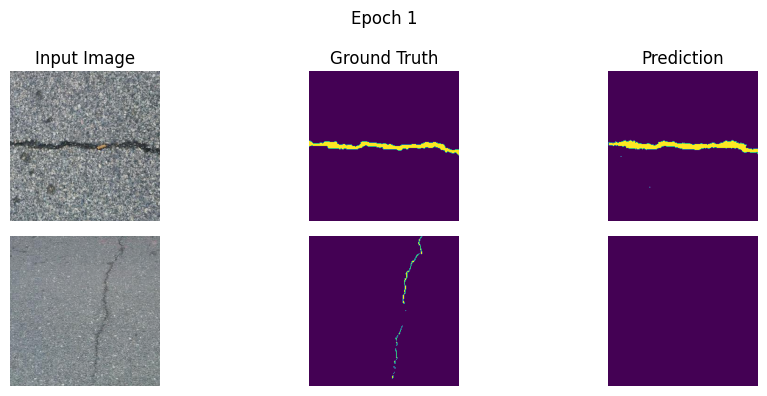

Train - Loss: 0.0691, Dice: 0.7331, IoU: 0.6651
Val   - Loss: 0.0614, Dice: 0.7064, IoU: 0.6484

Epoch 2/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.1416/6.2531
Loss value: 0.0415


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0289, dice=0.6568, iou=0.5892]


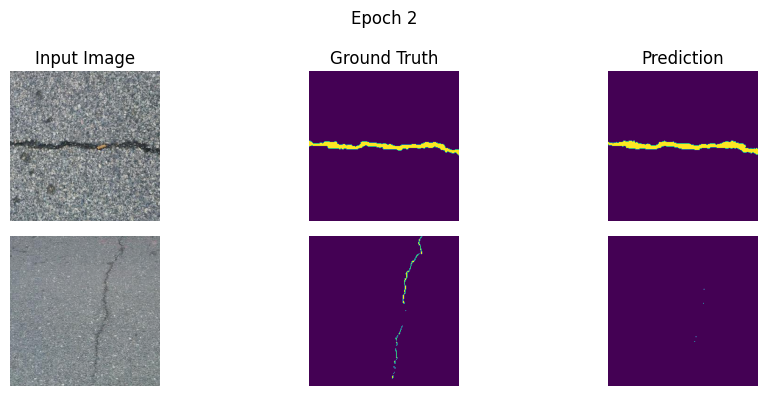

Train - Loss: 0.0511, Dice: 0.7638, IoU: 0.6942
Val   - Loss: 0.0555, Dice: 0.7264, IoU: 0.6633

Epoch 3/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])


Training:   0%|          | 1/750 [00:00<03:38,  3.42it/s, loss=0.0652, dice=0.8530, iou=0.7669]

Output min/max: -5.5996/6.8644
Loss value: 0.0652


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0557, dice=0.8077, iou=0.7173]


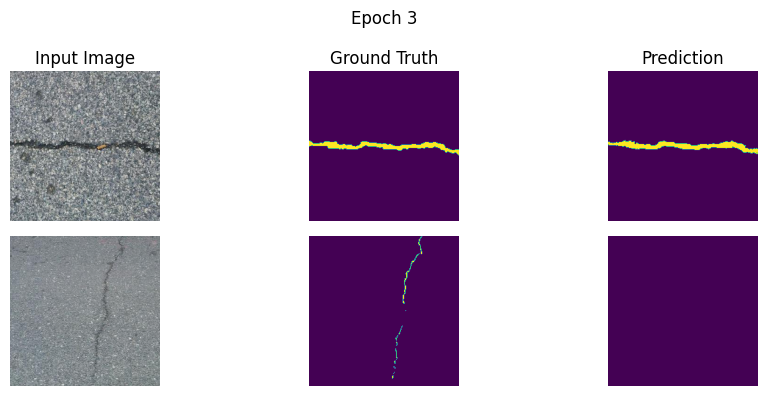

Train - Loss: 0.0478, Dice: 0.7784, IoU: 0.7089
Val   - Loss: 0.0519, Dice: 0.7137, IoU: 0.6549

Epoch 4/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -4.6624/5.5438
Loss value: 0.0178


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0275, dice=0.8775, iou=0.8013]


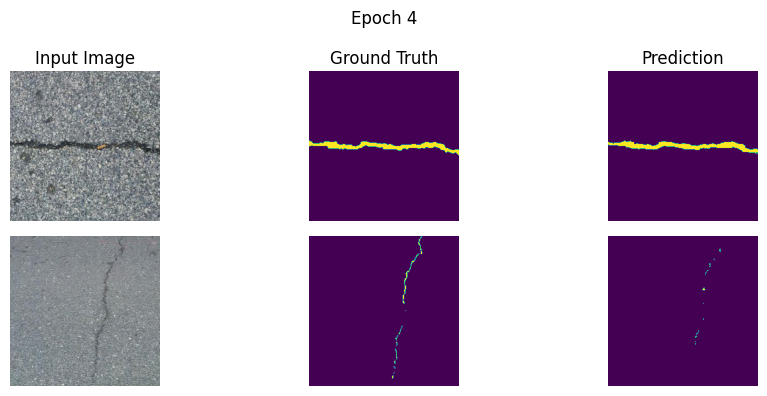

Train - Loss: 0.0460, Dice: 0.7810, IoU: 0.7104
Val   - Loss: 0.0485, Dice: 0.7222, IoU: 0.6612

Epoch 5/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -5.6203/6.4713
Loss value: 0.0165


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0957, dice=0.5664, iou=0.5238]


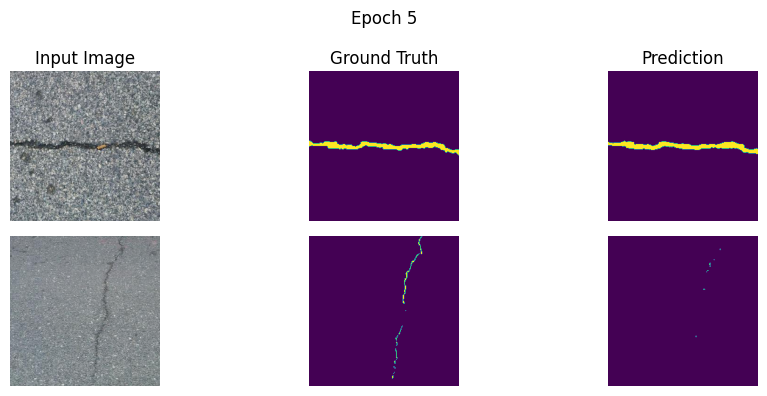

Train - Loss: 0.0427, Dice: 0.7902, IoU: 0.7201
Val   - Loss: 0.0485, Dice: 0.7149, IoU: 0.6570

Epoch 6/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.5197/7.8846
Loss value: 0.0514


Training: 100%|██████████| 750/750 [01:41<00:00,  7.41it/s, loss=0.0302, dice=0.8400, iou=0.7549]


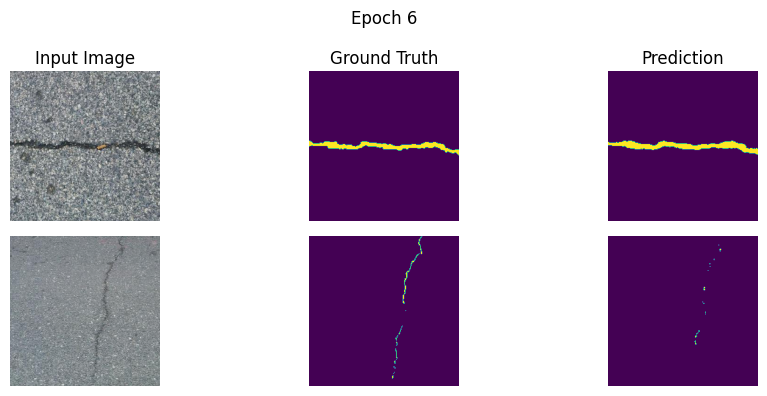

Train - Loss: 0.0423, Dice: 0.7929, IoU: 0.7231
Val   - Loss: 0.0488, Dice: 0.7518, IoU: 0.6849

Epoch 7/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])


Training:   0%|          | 1/750 [00:00<03:41,  3.38it/s, loss=0.0248, dice=0.5811, iou=0.5408]

Output min/max: -6.1128/7.6521
Loss value: 0.0248


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0227, dice=0.9409, iou=0.8933]


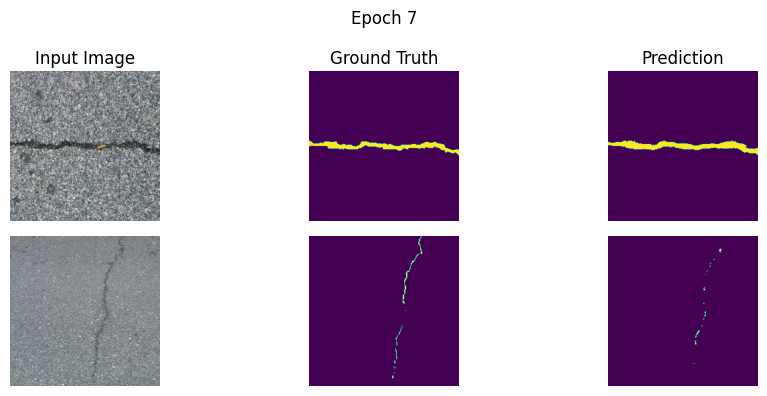

Train - Loss: 0.0410, Dice: 0.7920, IoU: 0.7231
Val   - Loss: 0.0457, Dice: 0.7538, IoU: 0.6876

Epoch 8/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<03:45,  3.33it/s, loss=0.0163, dice=0.8978, iou=0.8295]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -5.5252/7.4731
Loss value: 0.0163


Training: 100%|██████████| 750/750 [01:41<00:00,  7.42it/s, loss=0.0386, dice=0.8865, iou=0.8124]


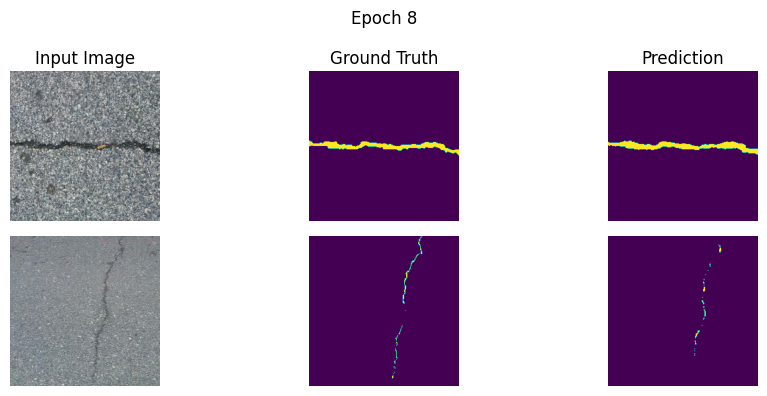

Train - Loss: 0.0394, Dice: 0.8013, IoU: 0.7323
Val   - Loss: 0.0515, Dice: 0.7304, IoU: 0.6675

Epoch 9/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.5467/8.1489
Loss value: 0.0180


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0731, dice=0.7347, iou=0.6473]


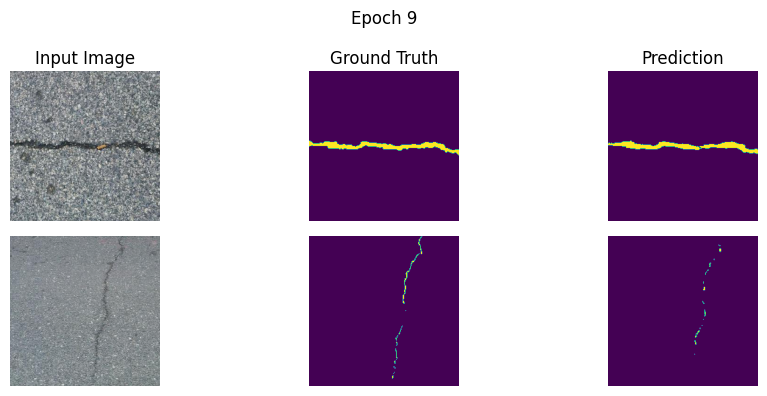

Train - Loss: 0.0393, Dice: 0.8036, IoU: 0.7334
Val   - Loss: 0.0468, Dice: 0.7321, IoU: 0.6681

Epoch 10/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.5668/8.1996
Loss value: 0.0235


Training: 100%|██████████| 750/750 [01:40<00:00,  7.43it/s, loss=0.0494, dice=0.5886, iou=0.5405]


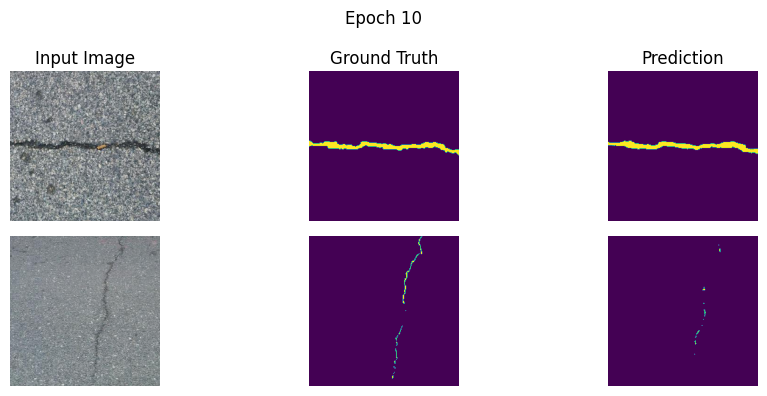

Train - Loss: 0.0379, Dice: 0.8054, IoU: 0.7365
Val   - Loss: 0.0460, Dice: 0.7401, IoU: 0.6747

Epoch 11/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.7739/9.1117
Loss value: 0.0274


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0165, dice=0.9280, iou=0.8734]


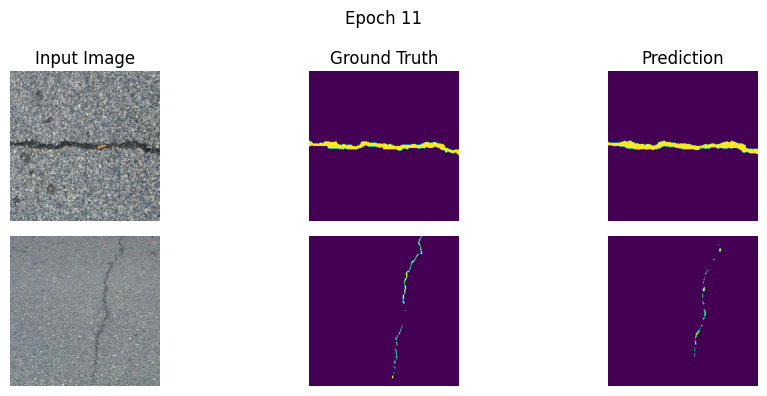

Train - Loss: 0.0354, Dice: 0.8089, IoU: 0.7407
Val   - Loss: 0.0453, Dice: 0.7545, IoU: 0.6866

Epoch 12/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.4098/8.3495
Loss value: 0.0260


Training: 100%|██████████| 750/750 [01:40<00:00,  7.43it/s, loss=0.0355, dice=0.8766, iou=0.7995]


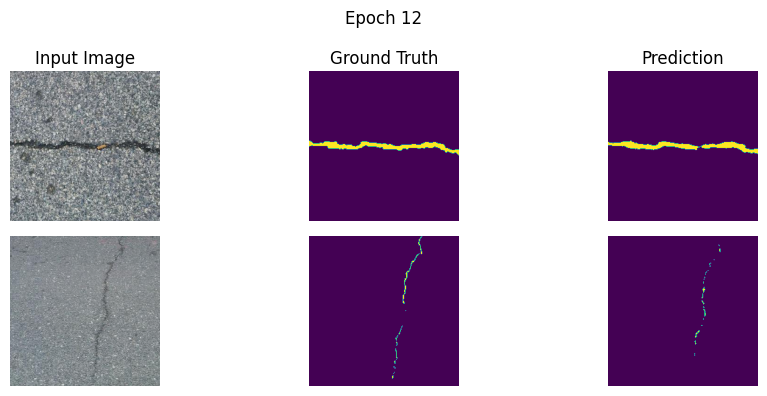

Train - Loss: 0.0346, Dice: 0.8114, IoU: 0.7433
Val   - Loss: 0.0543, Dice: 0.7113, IoU: 0.6495

Epoch 13/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.5083/8.2181
Loss value: 0.0544


Training: 100%|██████████| 750/750 [01:40<00:00,  7.46it/s, loss=0.0339, dice=0.8708, iou=0.7921]


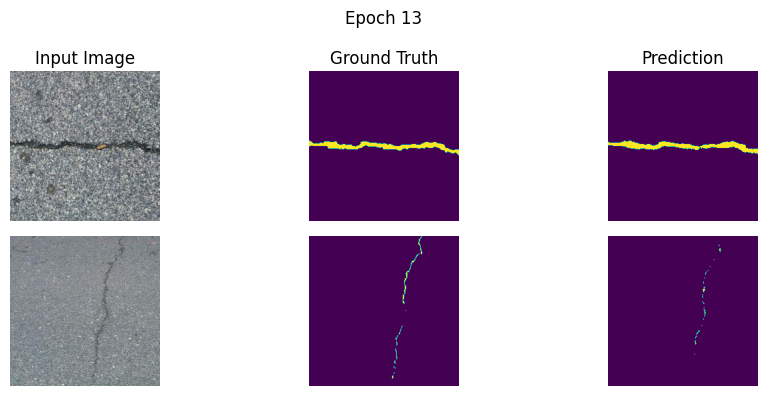

Train - Loss: 0.0340, Dice: 0.8103, IoU: 0.7436
Val   - Loss: 0.0490, Dice: 0.7393, IoU: 0.6736

Epoch 14/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -7.1762/8.8858
Loss value: 0.0166


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0357, dice=0.9230, iou=0.8645]


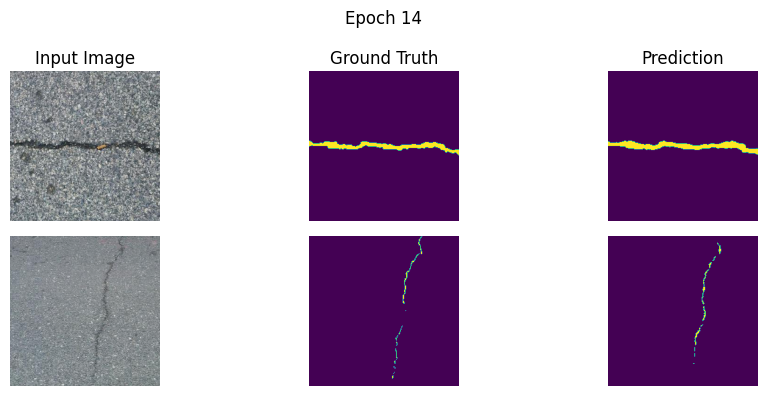

Train - Loss: 0.0332, Dice: 0.8142, IoU: 0.7471
Val   - Loss: 0.0465, Dice: 0.7743, IoU: 0.7029

Epoch 15/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.5065/8.6351
Loss value: 0.0283


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0289, dice=0.7274, iou=0.6436]


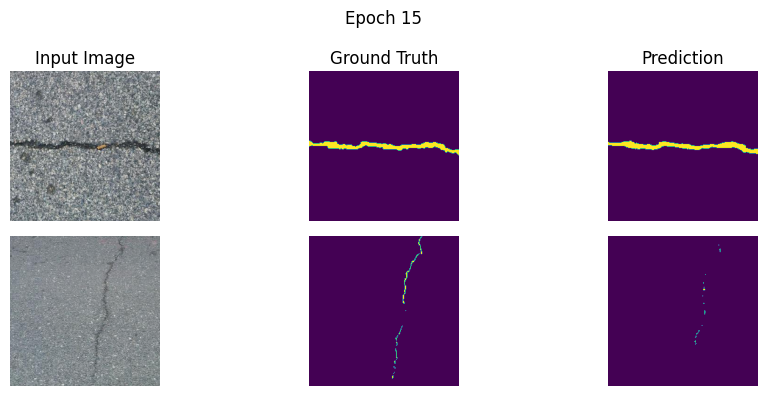

Train - Loss: 0.0321, Dice: 0.8208, IoU: 0.7540
Val   - Loss: 0.0449, Dice: 0.7409, IoU: 0.6752

Epoch 16/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -6.5325/8.5514
Loss value: 0.0180


Training: 100%|██████████| 750/750 [01:40<00:00,  7.43it/s, loss=0.0550, dice=0.9108, iou=0.8452]


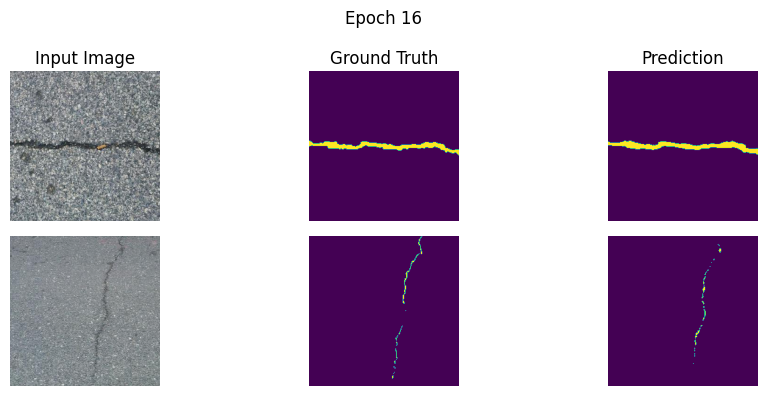

Train - Loss: 0.0316, Dice: 0.8196, IoU: 0.7536
Val   - Loss: 0.0454, Dice: 0.7601, IoU: 0.6920

Epoch 17/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -7.2362/9.2153
Loss value: 0.0209


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0156, dice=0.8988, iou=0.8307]


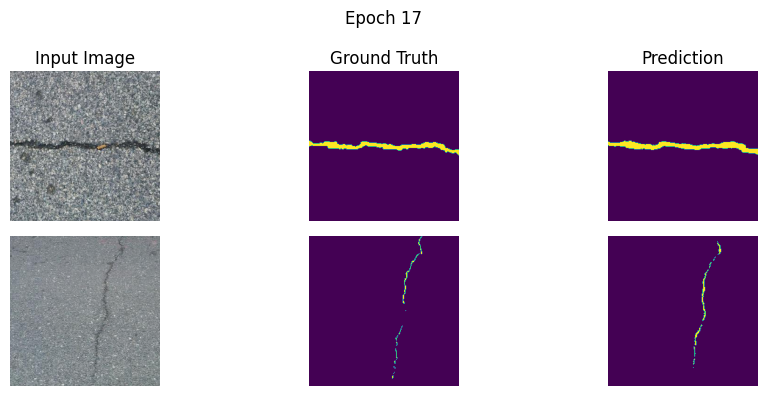

Train - Loss: 0.0310, Dice: 0.8234, IoU: 0.7563
Val   - Loss: 0.0459, Dice: 0.7605, IoU: 0.6915

Epoch 18/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -7.2303/9.5209
Loss value: 0.0474


Training: 100%|██████████| 750/750 [01:40<00:00,  7.46it/s, loss=0.0411, dice=0.7986, iou=0.7085]


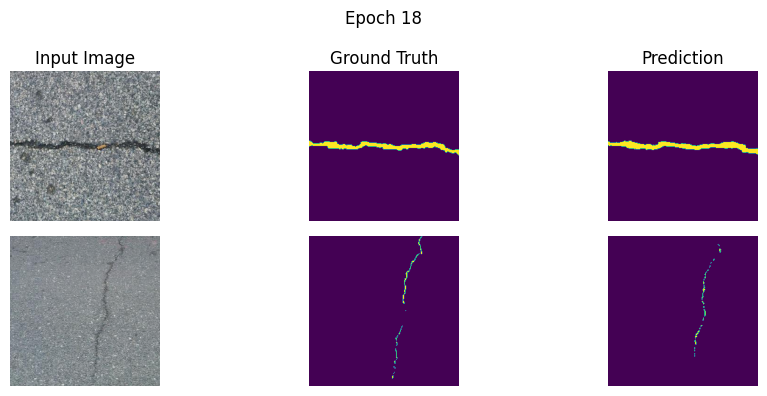

Train - Loss: 0.0306, Dice: 0.8238, IoU: 0.7571
Val   - Loss: 0.0471, Dice: 0.7583, IoU: 0.6898

Epoch 19/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -7.5970/9.7081
Loss value: 0.0213


Training: 100%|██████████| 750/750 [01:40<00:00,  7.46it/s, loss=0.0311, dice=0.8842, iou=0.8102]


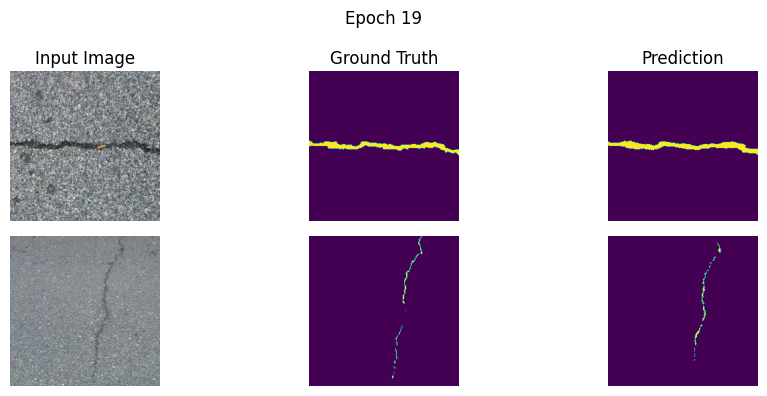

Train - Loss: 0.0300, Dice: 0.8219, IoU: 0.7566
Val   - Loss: 0.0467, Dice: 0.7625, IoU: 0.6933

Epoch 20/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.2743/10.0882
Loss value: 0.0225


Training: 100%|██████████| 750/750 [01:40<00:00,  7.47it/s, loss=0.0332, dice=0.9149, iou=0.8527]


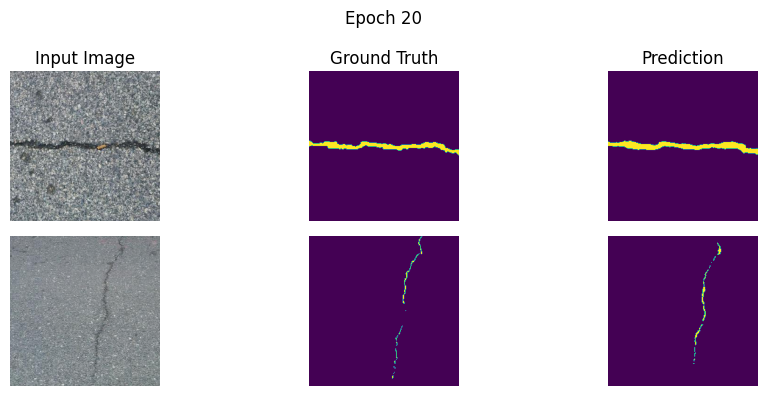

Train - Loss: 0.0298, Dice: 0.8221, IoU: 0.7571
Val   - Loss: 0.0461, Dice: 0.7625, IoU: 0.6940

Epoch 21/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -7.6478/9.7973
Loss value: 0.0202


Training: 100%|██████████| 750/750 [01:40<00:00,  7.43it/s, loss=0.0144, dice=0.5189, iou=0.5077]


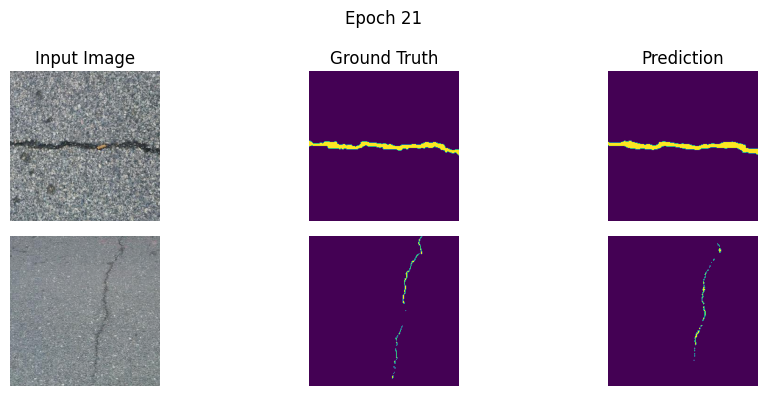

Train - Loss: 0.0295, Dice: 0.8268, IoU: 0.7616
Val   - Loss: 0.0467, Dice: 0.7597, IoU: 0.6915

Epoch 22/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.3174/10.5873
Loss value: 0.0204


Training: 100%|██████████| 750/750 [01:40<00:00,  7.46it/s, loss=0.0579, dice=0.8932, iou=0.8201]


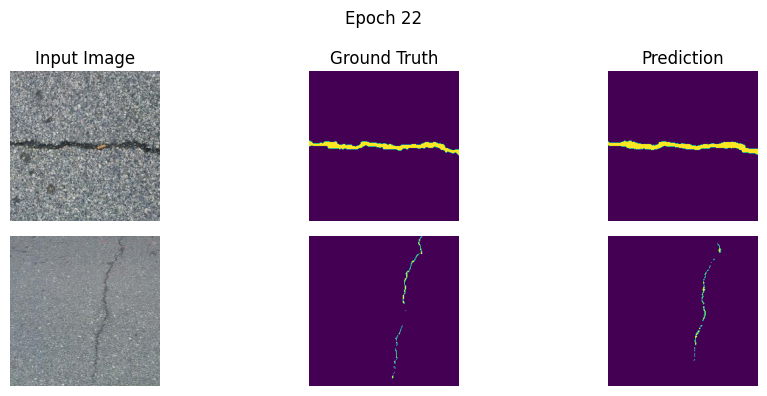

Train - Loss: 0.0293, Dice: 0.8291, IoU: 0.7634
Val   - Loss: 0.0466, Dice: 0.7604, IoU: 0.6916

Epoch 23/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -7.9689/10.1617
Loss value: 0.0433


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0191, dice=0.8932, iou=0.8228]


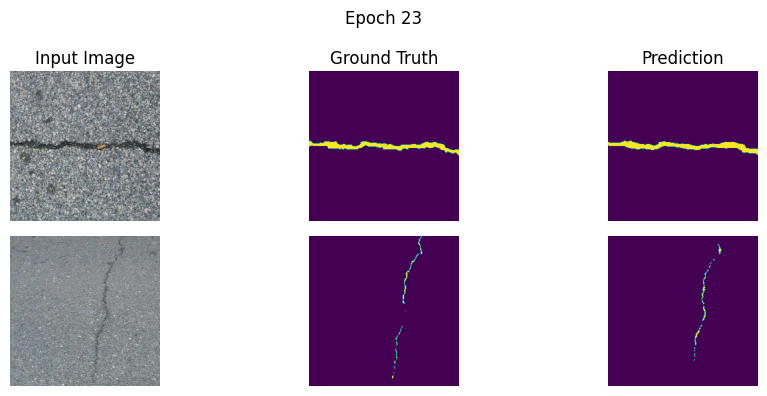

Train - Loss: 0.0290, Dice: 0.8291, IoU: 0.7638
Val   - Loss: 0.0464, Dice: 0.7571, IoU: 0.6889

Epoch 24/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.9397/11.6918
Loss value: 0.0474


Training: 100%|██████████| 750/750 [01:40<00:00,  7.46it/s, loss=0.0298, dice=0.9283, iou=0.8730]


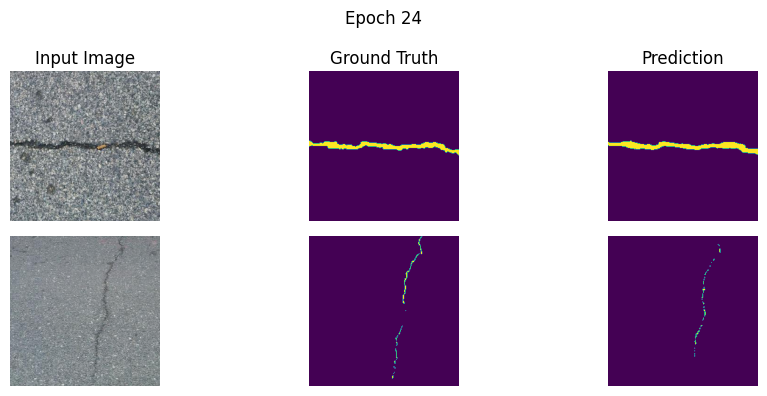

Train - Loss: 0.0289, Dice: 0.8247, IoU: 0.7606
Val   - Loss: 0.0474, Dice: 0.7480, IoU: 0.6817

Epoch 25/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])


Training:   0%|          | 1/750 [00:00<03:40,  3.40it/s, loss=0.0188, dice=0.8609, iou=0.7808]

Output min/max: -8.5512/10.5580
Loss value: 0.0188


Training: 100%|██████████| 750/750 [01:40<00:00,  7.43it/s, loss=0.0201, dice=0.9063, iou=0.8409]


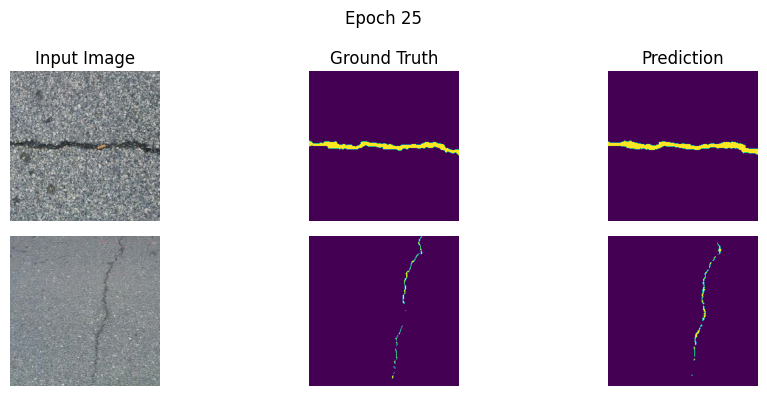

Train - Loss: 0.0288, Dice: 0.8288, IoU: 0.7639
Val   - Loss: 0.0479, Dice: 0.7642, IoU: 0.6948

Epoch 26/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.7901/11.3486
Loss value: 0.0398


Training: 100%|██████████| 750/750 [01:40<00:00,  7.47it/s, loss=0.0204, dice=0.7453, iou=0.6602]


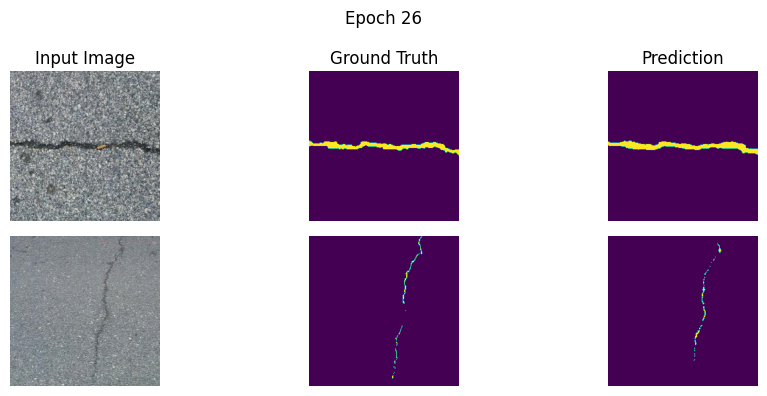

Train - Loss: 0.0287, Dice: 0.8315, IoU: 0.7663
Val   - Loss: 0.0485, Dice: 0.7593, IoU: 0.6900

Epoch 27/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.6097/10.6820
Loss value: 0.0208


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0170, dice=0.5554, iou=0.5267]


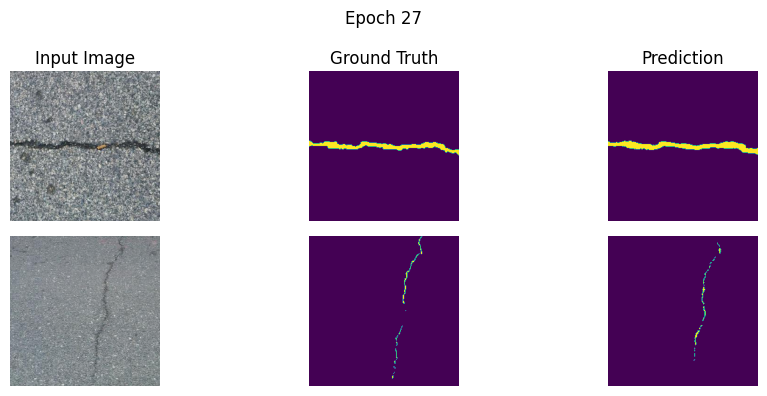

Train - Loss: 0.0287, Dice: 0.8278, IoU: 0.7625
Val   - Loss: 0.0488, Dice: 0.7537, IoU: 0.6865

Epoch 28/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.8716/11.1816
Loss value: 0.1087


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0255, dice=0.8632, iou=0.7831]


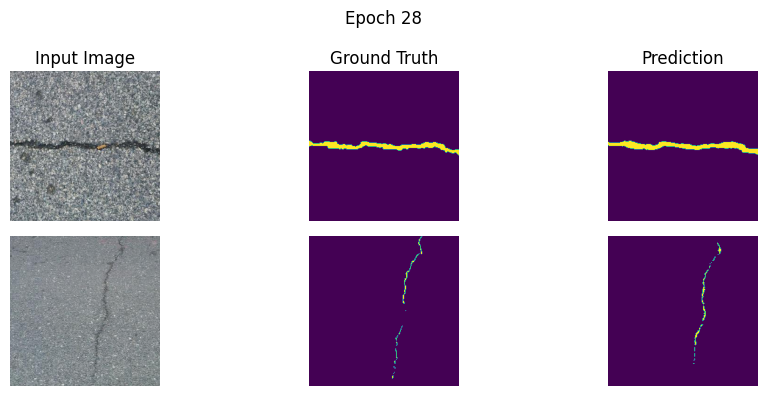

Train - Loss: 0.0284, Dice: 0.8283, IoU: 0.7636
Val   - Loss: 0.0475, Dice: 0.7622, IoU: 0.6931

Epoch 29/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -9.2142/12.1894
Loss value: 0.0630


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0324, dice=0.6419, iou=0.5775]


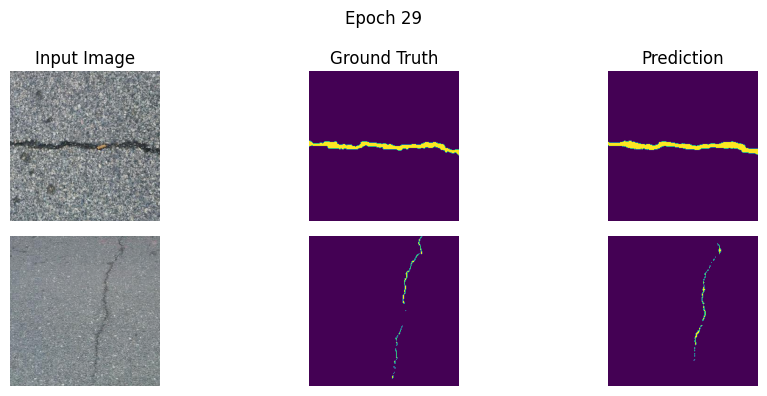

Train - Loss: 0.0285, Dice: 0.8298, IoU: 0.7649
Val   - Loss: 0.0482, Dice: 0.7529, IoU: 0.6856

Epoch 30/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<03:59,  3.12it/s, loss=0.0302, dice=0.7255, iou=0.6427]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -9.8092/11.1941
Loss value: 0.0302


Training: 100%|██████████| 750/750 [01:40<00:00,  7.46it/s, loss=0.0289, dice=0.8993, iou=0.8308]


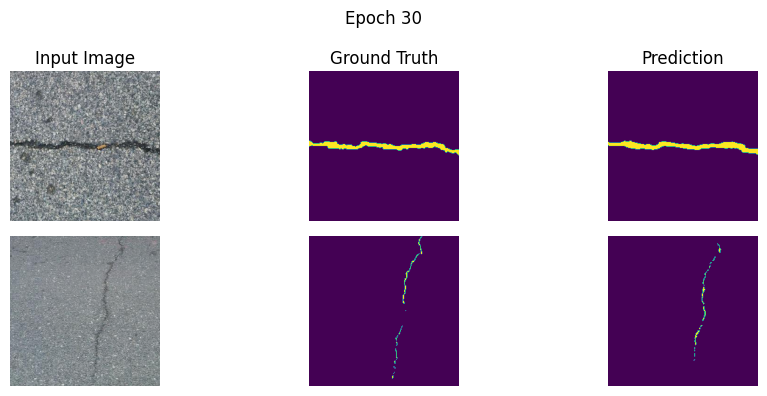

Train - Loss: 0.0285, Dice: 0.8312, IoU: 0.7660
Val   - Loss: 0.0476, Dice: 0.7532, IoU: 0.6861

Epoch 31/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.7123/11.5836
Loss value: 0.0508


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0797, dice=0.7522, iou=0.6595]


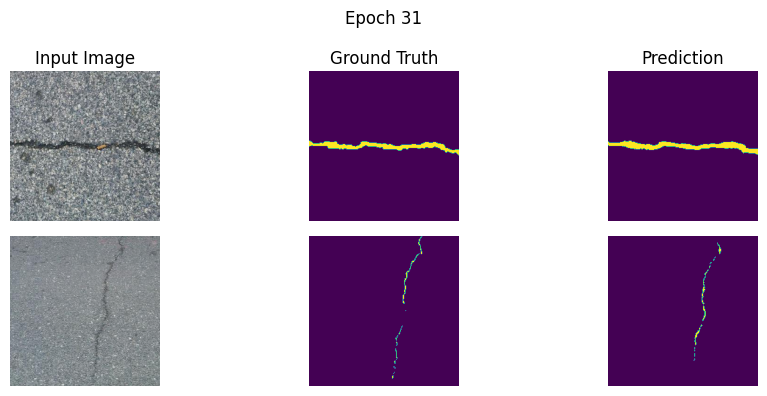

Train - Loss: 0.0284, Dice: 0.8314, IoU: 0.7664
Val   - Loss: 0.0484, Dice: 0.7601, IoU: 0.6909

Epoch 32/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<03:45,  3.32it/s, loss=0.0423, dice=0.9274, iou=0.8712]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.1134/10.5944
Loss value: 0.0423


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0308, dice=0.6189, iou=0.5636]


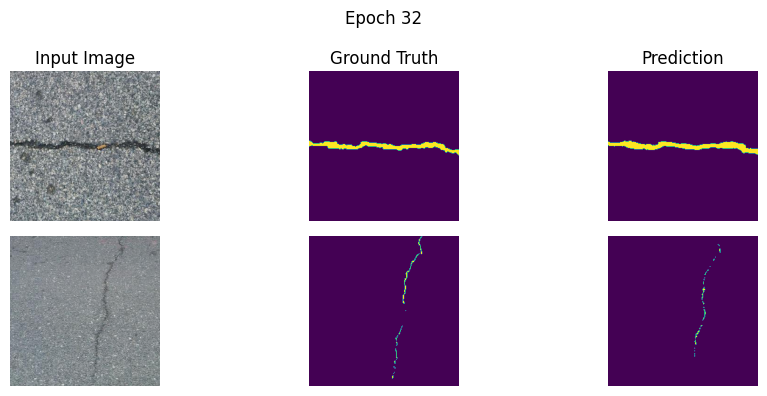

Train - Loss: 0.0284, Dice: 0.8290, IoU: 0.7639
Val   - Loss: 0.0508, Dice: 0.7483, IoU: 0.6810

Epoch 33/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.0469/10.1797
Loss value: 0.0292


Training: 100%|██████████| 750/750 [01:41<00:00,  7.40it/s, loss=0.0388, dice=0.6890, iou=0.6115]


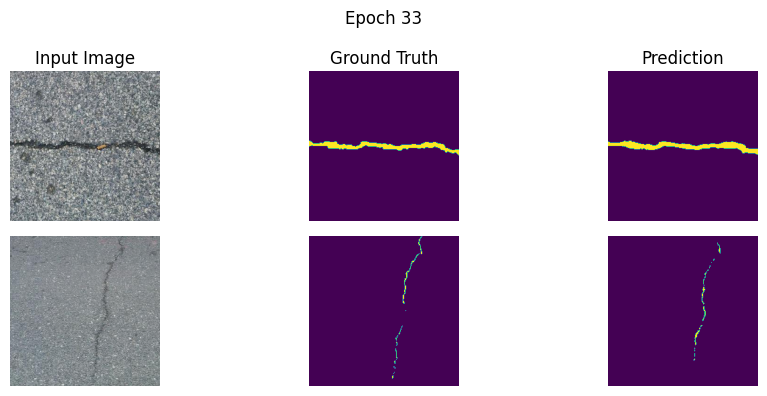

Train - Loss: 0.0285, Dice: 0.8302, IoU: 0.7653
Val   - Loss: 0.0489, Dice: 0.7581, IoU: 0.6897

Epoch 34/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.3047/10.1886
Loss value: 0.0194


Training: 100%|██████████| 750/750 [01:41<00:00,  7.42it/s, loss=0.0165, dice=0.5704, iou=0.5360]


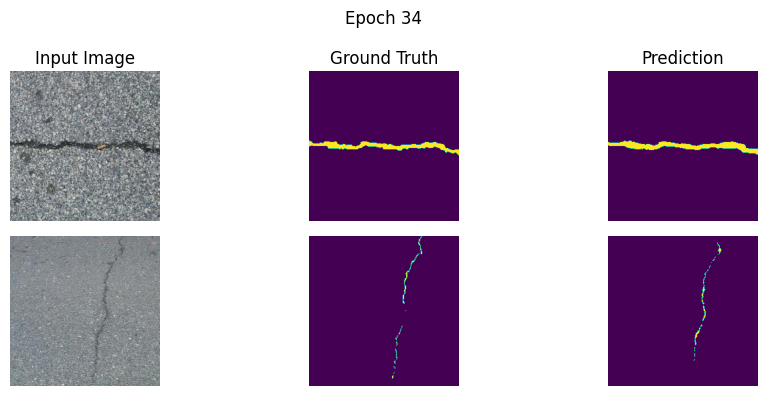

Train - Loss: 0.0283, Dice: 0.8302, IoU: 0.7660
Val   - Loss: 0.0477, Dice: 0.7543, IoU: 0.6870

Epoch 35/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.5114/10.3931
Loss value: 0.0399


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0162, dice=0.9309, iou=0.8780]


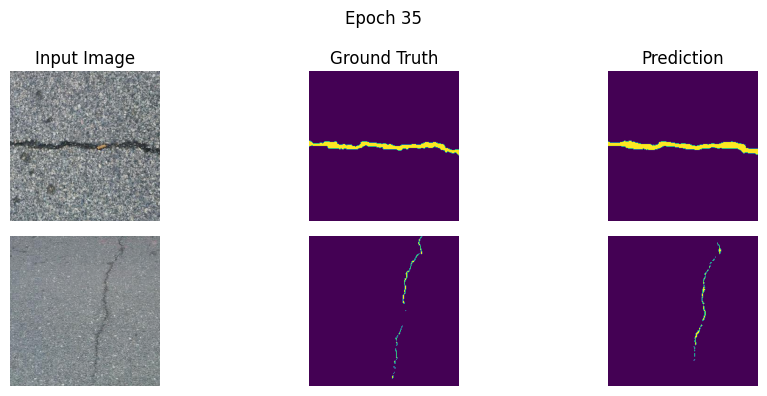

Train - Loss: 0.0283, Dice: 0.8283, IoU: 0.7643
Val   - Loss: 0.0472, Dice: 0.7585, IoU: 0.6904

Epoch 36/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -9.5756/11.4880
Loss value: 0.0225


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0232, dice=0.9220, iou=0.8637]


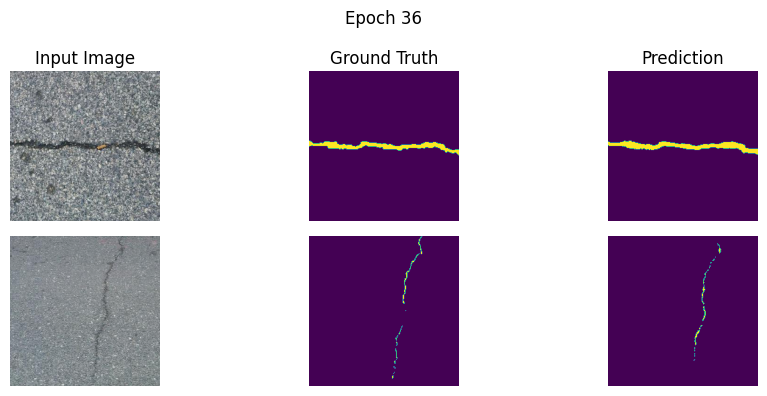

Train - Loss: 0.0283, Dice: 0.8304, IoU: 0.7655
Val   - Loss: 0.0476, Dice: 0.7576, IoU: 0.6896

Epoch 37/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<04:08,  3.01it/s, loss=0.0417, dice=0.8764, iou=0.7988]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -9.7671/12.3393
Loss value: 0.0417


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.1079, dice=0.5926, iou=0.5362]


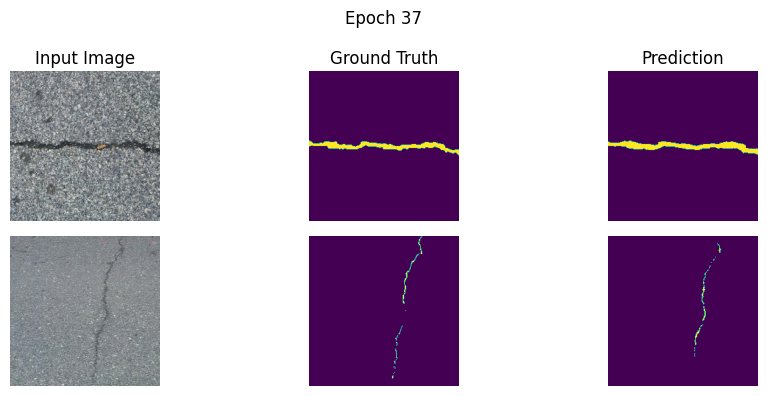

Train - Loss: 0.0283, Dice: 0.8288, IoU: 0.7641
Val   - Loss: 0.0488, Dice: 0.7511, IoU: 0.6848

Epoch 38/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.9722/12.0705
Loss value: 0.0357


Training: 100%|██████████| 750/750 [01:40<00:00,  7.43it/s, loss=0.0311, dice=0.9379, iou=0.8882]


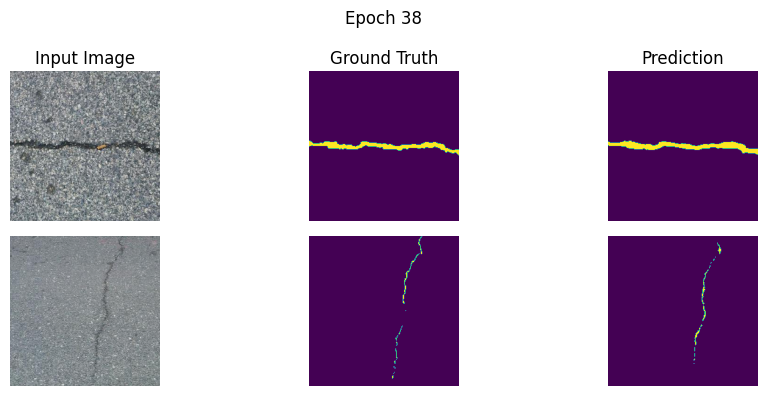

Train - Loss: 0.0284, Dice: 0.8330, IoU: 0.7677
Val   - Loss: 0.0475, Dice: 0.7621, IoU: 0.6932

Epoch 39/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])


Training:   0%|          | 1/750 [00:00<03:38,  3.43it/s, loss=0.0209, dice=0.8914, iou=0.8202]

Output min/max: -8.7718/12.0177
Loss value: 0.0209


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0126, dice=0.8416, iou=0.7584]


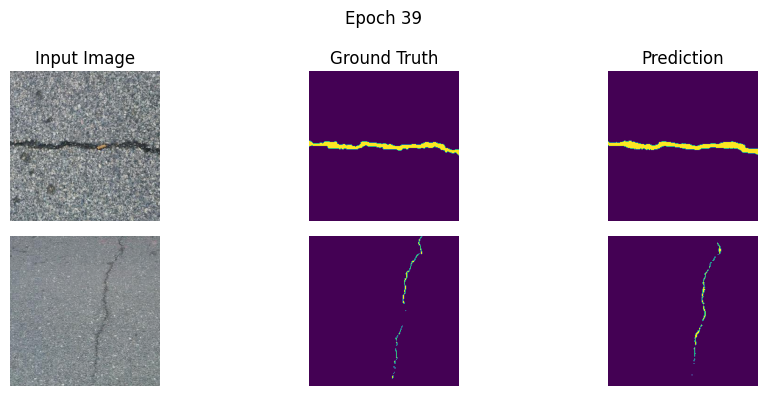

Train - Loss: 0.0284, Dice: 0.8297, IoU: 0.7652
Val   - Loss: 0.0492, Dice: 0.7555, IoU: 0.6873

Epoch 40/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.5243/12.2598
Loss value: 0.0268


Training: 100%|██████████| 750/750 [01:40<00:00,  7.43it/s, loss=0.0491, dice=0.8570, iou=0.7736]


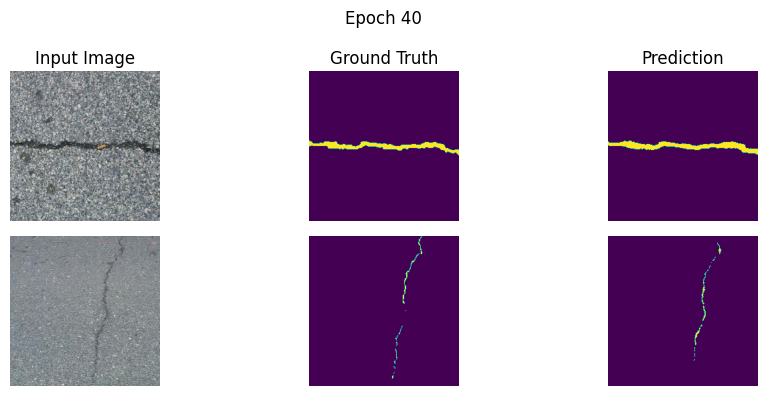

Train - Loss: 0.0283, Dice: 0.8303, IoU: 0.7664
Val   - Loss: 0.0478, Dice: 0.7550, IoU: 0.6874

Epoch 41/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<03:54,  3.19it/s, loss=0.0106, dice=0.8702, iou=0.7931]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.1704/10.4578
Loss value: 0.0106


Training: 100%|██████████| 750/750 [01:41<00:00,  7.42it/s, loss=0.0119, dice=0.9171, iou=0.8572]


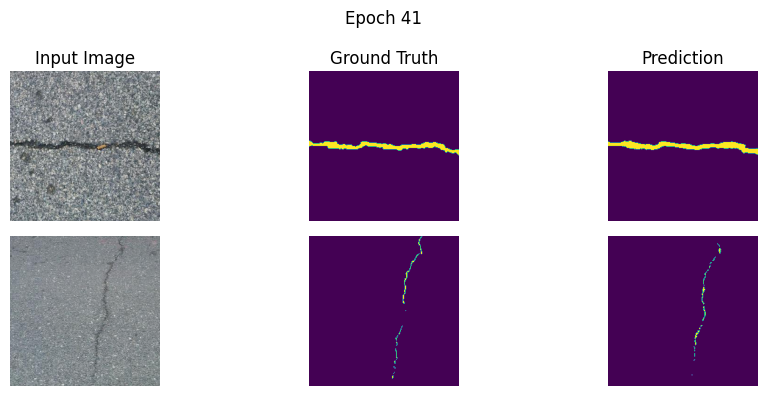

Train - Loss: 0.0282, Dice: 0.8308, IoU: 0.7661
Val   - Loss: 0.0480, Dice: 0.7550, IoU: 0.6878

Epoch 42/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<03:47,  3.30it/s, loss=0.0265, dice=0.8823, iou=0.8074]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.3584/11.1318
Loss value: 0.0265


Training: 100%|██████████| 750/750 [01:41<00:00,  7.42it/s, loss=0.0300, dice=0.6746, iou=0.6016]


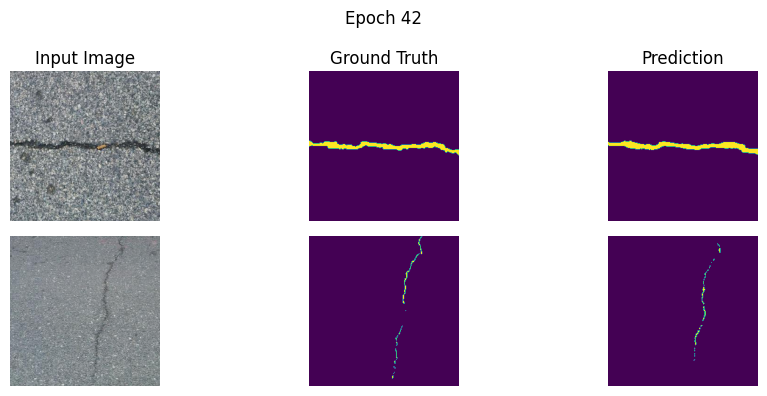

Train - Loss: 0.0284, Dice: 0.8284, IoU: 0.7640
Val   - Loss: 0.0476, Dice: 0.7530, IoU: 0.6862

Epoch 43/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<03:49,  3.26it/s, loss=0.0278, dice=0.8505, iou=0.7675]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.7905/10.2818
Loss value: 0.0278


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0099, dice=0.9222, iou=0.8648]


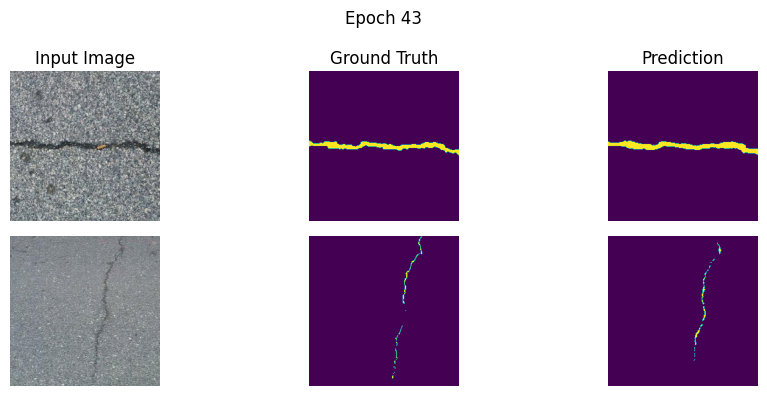

Train - Loss: 0.0284, Dice: 0.8304, IoU: 0.7654
Val   - Loss: 0.0480, Dice: 0.7655, IoU: 0.6957

Epoch 44/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<04:08,  3.01it/s, loss=0.0134, dice=0.9291, iou=0.8752]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -9.3777/11.1224
Loss value: 0.0134


Training: 100%|██████████| 750/750 [01:41<00:00,  7.42it/s, loss=0.0173, dice=0.9424, iou=0.8961]


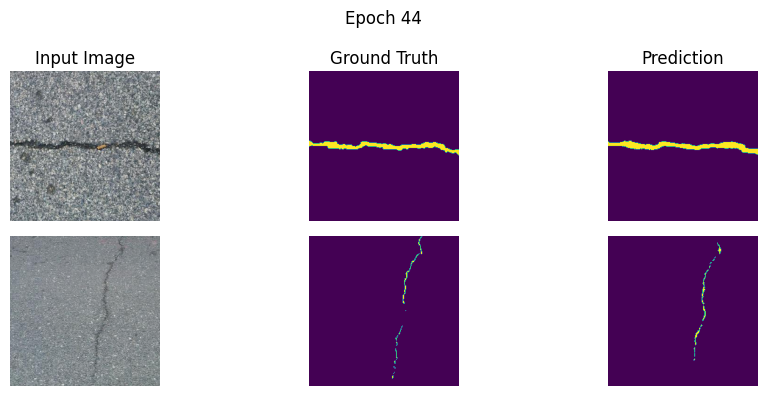

Train - Loss: 0.0283, Dice: 0.8297, IoU: 0.7646
Val   - Loss: 0.0480, Dice: 0.7579, IoU: 0.6901

Epoch 45/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.1842/10.2849
Loss value: 0.0227


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0273, dice=0.9484, iou=0.9053]


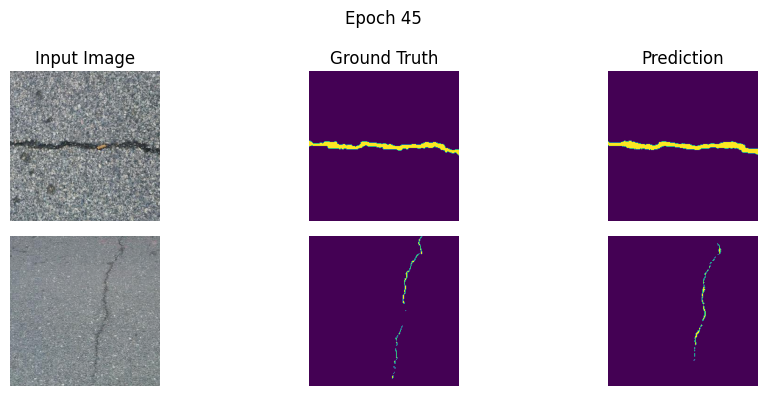

Train - Loss: 0.0283, Dice: 0.8301, IoU: 0.7658
Val   - Loss: 0.0478, Dice: 0.7561, IoU: 0.6883

Epoch 46/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.1054/10.4434
Loss value: 0.0190


Training: 100%|██████████| 750/750 [01:41<00:00,  7.41it/s, loss=0.0139, dice=0.9376, iou=0.8886]


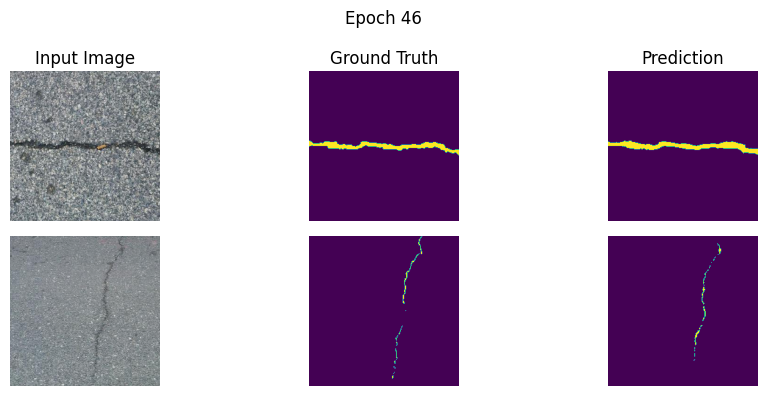

Train - Loss: 0.0285, Dice: 0.8299, IoU: 0.7655
Val   - Loss: 0.0487, Dice: 0.7516, IoU: 0.6848

Epoch 47/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.4338/9.9299
Loss value: 0.0195


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0398, dice=0.8737, iou=0.7960]


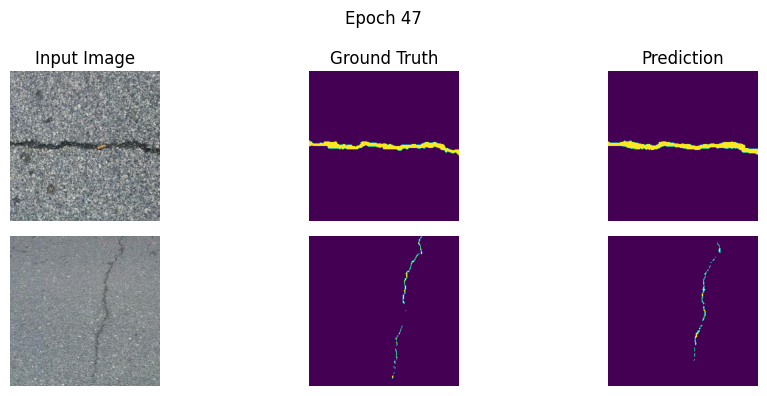

Train - Loss: 0.0283, Dice: 0.8297, IoU: 0.7645
Val   - Loss: 0.0482, Dice: 0.7560, IoU: 0.6885

Epoch 48/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])


Training:   0%|          | 1/750 [00:00<03:39,  3.41it/s, loss=0.0146, dice=0.9195, iou=0.8606]

Output min/max: -8.3137/10.7644
Loss value: 0.0146


Training: 100%|██████████| 750/750 [01:41<00:00,  7.41it/s, loss=0.0290, dice=0.9210, iou=0.8621]


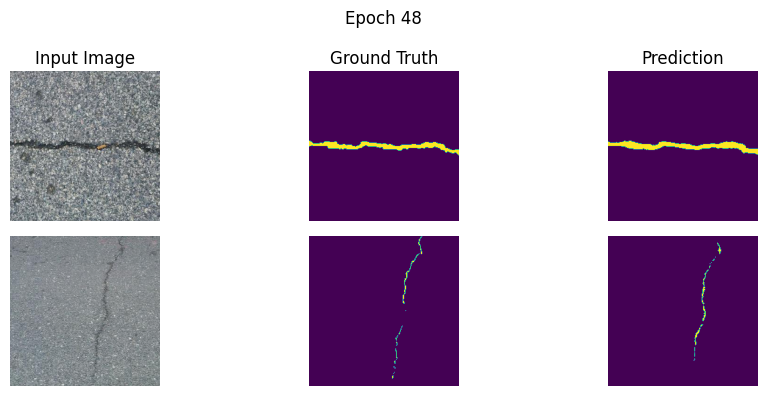

Train - Loss: 0.0284, Dice: 0.8263, IoU: 0.7617
Val   - Loss: 0.0475, Dice: 0.7632, IoU: 0.6941

Epoch 49/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]


Training:   0%|          | 1/750 [00:00<03:52,  3.22it/s, loss=0.0216, dice=0.9586, iou=0.9230]

Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.3028/11.0041
Loss value: 0.0216


Training: 100%|██████████| 750/750 [01:40<00:00,  7.44it/s, loss=0.0108, dice=0.6025, iou=0.5556]


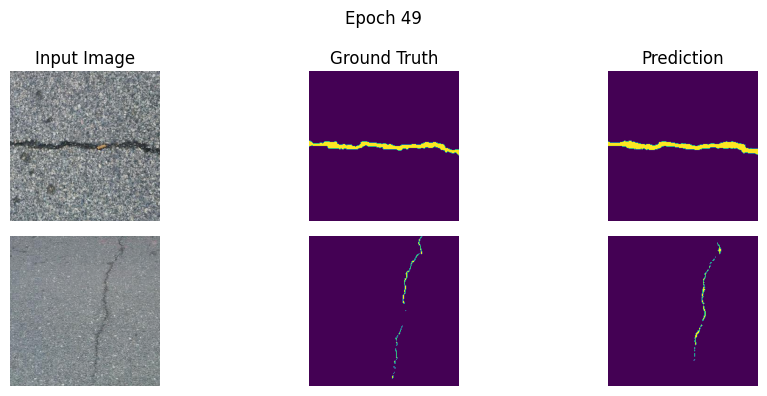

Train - Loss: 0.0283, Dice: 0.8270, IoU: 0.7626
Val   - Loss: 0.0479, Dice: 0.7593, IoU: 0.6910

Epoch 50/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -9.0482/11.7483
Loss value: 0.0300


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0133, dice=0.5036, iou=0.5002]


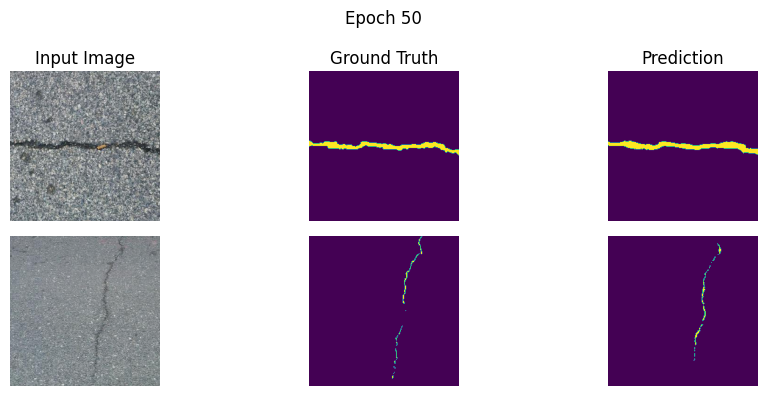

Train - Loss: 0.0283, Dice: 0.8278, IoU: 0.7641
Val   - Loss: 0.0488, Dice: 0.7561, IoU: 0.6882

Epoch 51/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])


Training:   0%|          | 1/750 [00:00<03:40,  3.40it/s, loss=0.0263, dice=0.7612, iou=0.6736]

Output min/max: -8.6801/11.2800
Loss value: 0.0263


Training: 100%|██████████| 750/750 [01:40<00:00,  7.45it/s, loss=0.0559, dice=0.8654, iou=0.7832]


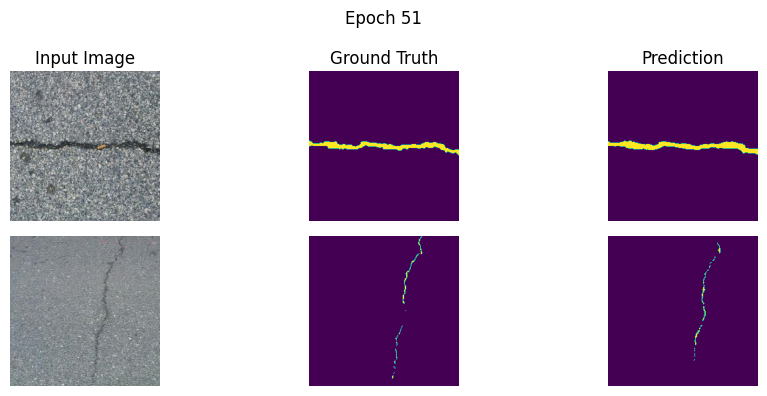

Train - Loss: 0.0284, Dice: 0.8335, IoU: 0.7685
Val   - Loss: 0.0481, Dice: 0.7629, IoU: 0.6938

Epoch 52/100


Training:   0%|          | 0/750 [00:00<?, ?it/s]


Debug - Batch shapes:
Images shape: torch.Size([2, 3, 224, 224])
Masks shape: torch.Size([2, 224, 224])
Unique mask values: [0, 1]
Outputs shape: torch.Size([2, 2, 224, 224])
Output min/max: -8.0761/10.6333
Loss value: 0.0152


Training:   1%|          | 7/750 [00:01<02:10,  5.68it/s, loss=0.0160, dice=0.9676, iou=0.9387]


Training interrupted by user


In [29]:
def main():
    # Training settings
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    batch_size = 2
    num_epochs = 100
    lr = 1e-4
    
    # Create datasets
    train_dataset = UDTIRICrackDataset(split='train', transform=get_transforms(train=True))
    val_dataset = UDTIRICrackDataset(split='val', transform=get_transforms(train=False))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Create model
    model = LM_Net(channel=3, n_classes=2)  
    model = model.to(device)
    
    # Loss and optimizer
    criterion = DiceCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    try:
        # Training loop
        for epoch in range(num_epochs):
            print(f'\nEpoch {epoch+1}/{num_epochs}')
            train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_metrics = validate(model, val_loader, criterion, device, epoch + 1)
            
            # Print metrics
            print(f'Train - Loss: {train_metrics["loss"]:.4f}, Dice: {train_metrics["dice"]:.4f}, IoU: {train_metrics["iou"]:.4f}')
            print(f'Val   - Loss: {val_metrics["loss"]:.4f}, Dice: {val_metrics["dice"]:.4f}, IoU: {val_metrics["iou"]:.4f}')
            
            # Update learning rate
            scheduler.step(val_metrics['loss'])
        
        print("\nTraining completed!")
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"\nError during training: {str(e)}")

if __name__ == '__main__':
    main() 